In [1]:
%matplotlib widget
%matplotlib inline
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pickle
import seaborn as sns
import scipy
import emcee
import corner
from IPython.display import display, Math
from tqdm import tqdm
from multiprocessing import Pool

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
import stingray.gti as sting_gti
import stingray.pulse.pulsar as plsr
# from stingray import stats


sns.set_context('paper', font_scale=3.0)
sns.set_palette("colorblind")

# sns.set_style("whitegrid")
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')

from stingray_plus import *
    
def FRED_plateau(time, t_0, tau_D, tau_R, t_plateau, A, C):
    # Fast Rise Exponential Decay with plateau from Barriere et al. 2015
    t = time-t_0
    t_peak = np.sqrt(tau_D*tau_R)
    
#     t[t<=0] = 1e-2
#     t[(t-t_plateau) == 0] = t_plateau + 1e-2
    
    rise_mask = ((t <= t_peak) * (t > 0))
    plateau_mask = ((t > t_peak) * (t <= (t_peak + t_plateau)))
    decay_mask = ((t > (t_peak + t_plateau)))
    
    model = np.zeros(np.shape(t))
    
    model[rise_mask] = np.exp(-((tau_R/t[rise_mask]) + (t[rise_mask]/tau_D)))
    model[plateau_mask] = np.exp(-2.0*np.sqrt(tau_R/tau_D))
    model[decay_mask] = np.exp(-((tau_R/(t[decay_mask]-t_plateau)) + ((t[decay_mask]-t_plateau)/tau_D)))
        
    return (A * model) + C

def FRED(time, t_0, tau_D, tau_R, A, C):
    # Fast Rise Exponential Decay with plateau from Barriere et al. 2015
    t = time-t_0
    
    rise_mask = (t > 0)
    model = np.zeros(np.shape(t))
    
    model[rise_mask] = np.exp(-((tau_R/t[rise_mask]) + (t[rise_mask]/tau_D)))        
    return (A * model) + C

def powerlaw_tail(time, t_0, tau_D, tau_R, A, gamma, t_tail, C):
    
    B = A*np.exp(-((tau_R/t_tail) + (t_tail/tau_D)))
    
    t = time-t_0
    rise_mask = (t > 0)
    model = np.zeros(np.shape(t))
    
    model[rise_mask] = np.power(t[rise_mask]/t_tail, -gamma)
    
    return (B*model) + C
    

def FRED_powerlaw(time, t_0, tau_D, tau_R, A, gamma, t_tail, C):
    # Fast Rise Exponential Decay with plateau from Barriere et al. 2015
    t = time-t_0
    
    fred_mask = (t > 0) * (t <= t_tail)
    pl_mask = (t > t_tail)
    model = np.zeros(np.shape(t))
    
    model[fred_mask] = A*np.exp(-((tau_R/t[fred_mask]) + (t[fred_mask]/tau_D)))
    
    B = A*np.exp(-((tau_R/t_tail) + (t_tail/tau_D)))
    
    model[pl_mask] = B*np.power(t[pl_mask]/t_tail, -gamma)
    return model + C

def FRED_2(time, t_1, tau_D1, tau_R1, A1, t_2, tau_D2, tau_R2, A2, C):
    # Fast Rise Exponential Decay with plateau from Barriere et al. 2015
    model1 = FRED(time, t_1, tau_D1, tau_R1, A1, C) - C
    model2 = FRED(time, t_2, tau_D2, tau_R2, A2, C) - C
    
    return model1 + model2 + C

/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/utils.py:21: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/crossspectrum.py:21: UserWarning: Using standard scipy fft
  warnings.warn("Using standard scipy fft")


# Analyze burst shape

In [2]:
if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/GRS_1741d9m2853/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir = '/Volumes/Samsung_1TB/AstroData/GRS_1741d9m2853/'

products_dir = root_dir + 'products_3to78keV/'
plot_dir = root_dir + 'figures/'


Working on Macbook


In [3]:
plt.ion()
curveA = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu90601317002A01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu90601317002A01_bk.lc'))
curveB = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu90601317002B01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu90601317002B01_bk.lc'))
curve_total = sum_lc(curveA, curveB)
print(curve_total.dt)
curve_10s = curve_total.rebin(dt_new=10.)

t_start = np.min(curve_total.time)


0.5


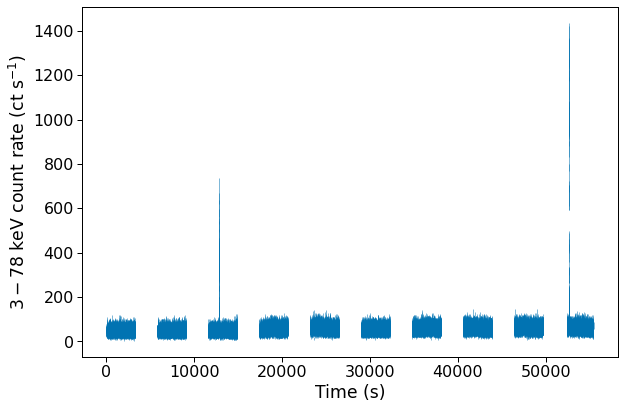

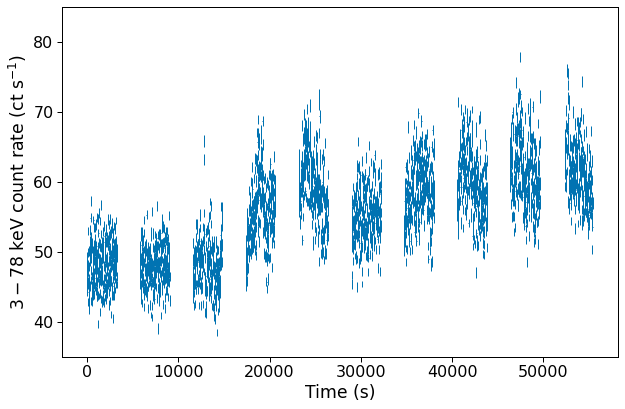

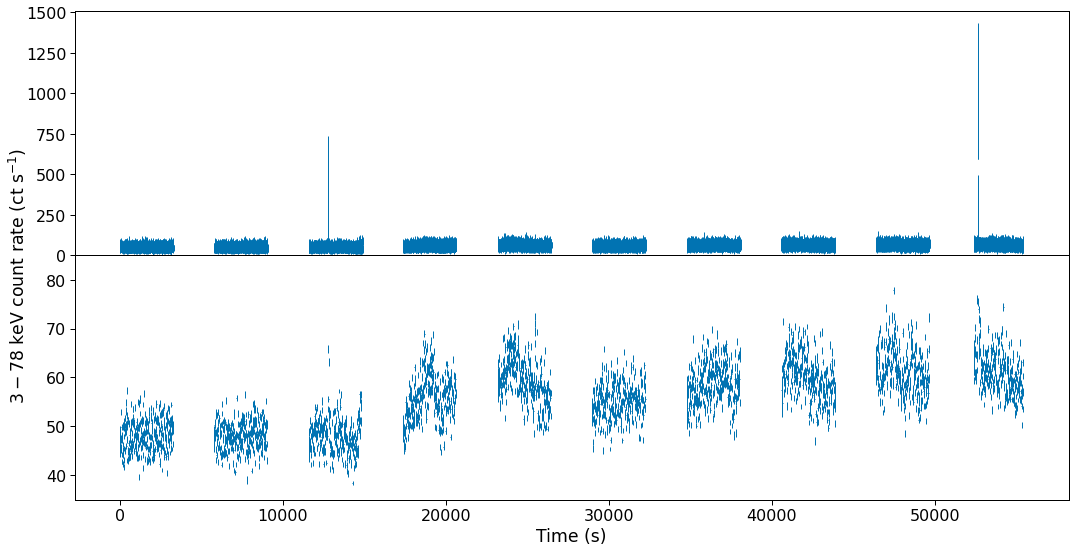

In [4]:
sns.set_context('paper', font_scale=1.8)

# plt.figure(figsize = (9,6))
# plt.errorbar(curveA.time-t_start, curveA.countrate, xerr=curveA.dt/2., yerr=curveA.countrate_err, fmt='none', lw = 0.5)
# plt.xlabel('Time (s)')
# plt.ylabel('NuSTAR count rate')

# plt.figure(figsize = (9,6))
# plt.errorbar(curveB.time-t_start, curveB.countrate, xerr=curveB.dt/2., yerr=curveB.countrate_err, fmt='none', lw = 0.5)
# plt.xlabel('Time (s)')
# plt.ylabel('NuSTAR count rate')

plt.figure(figsize = (9,6))
plt.errorbar(curve_total.time-t_start, curve_total.countrate, xerr=curve_total.dt/2., yerr=curve_total.countrate_err, fmt='none', lw = 0.5)
plt.xlabel('Time (s)')
plt.ylabel(r'$\mathrm{3-78\ keV\ count\ rate\ (ct\ s^{-1})}$')
plt.tight_layout()
plt.savefig(plot_dir+'clean_lightcurve.pdf')

plt.figure(figsize = (9,6))
plt.errorbar(curve_10s.time-t_start, curve_10s.countrate, xerr=curve_10s.dt/2., yerr=curve_10s.countrate_err, fmt='none', lw = 1.0)
plt.ylim((35,85))
plt.xlabel('Time (s)')
plt.ylabel(r'$\mathrm{3-78\ keV\ count\ rate\ (ct\ s^{-1})}$')
plt.tight_layout()
# plt.savefig(plot_dir+'clean_lightcurve_persistent.pdf')

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,8), sharex=True, gridspec_kw = {'height_ratios':[1,1], 'hspace':0})
ax1.errorbar(curve_total.time-t_start, curve_total.countrate, xerr=curve_total.dt/2., yerr=curve_total.countrate_err, fmt='none', lw = 1.0)
ax2.errorbar(curve_10s.time-t_start, curve_10s.countrate, xerr=curve_10s.dt/2., yerr=curve_10s.countrate_err, fmt='none', lw = 1.0)
fig.text(0, 0.5, str(r'$\mathrm{3-78\ keV\ count\ rate\ (ct\ s^{-1})}$'), va='center', rotation='vertical')
# ax1.set_ylabel(r'$\mathrm{3-78\ keV\ count\ rate\ (ct\ s^{-1})}$')
# ax2.set_ylabel(r'$\mathrm{3-78\ keV\ count\ rate\ (ct\ s^{-1})}$')
ax1.set_ylim(bottom=0)
ax2.set_ylim((35,85))
ax2.set_xlabel('Time (s)')
plt.tight_layout()
plt.savefig(plot_dir+'clean_lightcurve_combo.pdf')



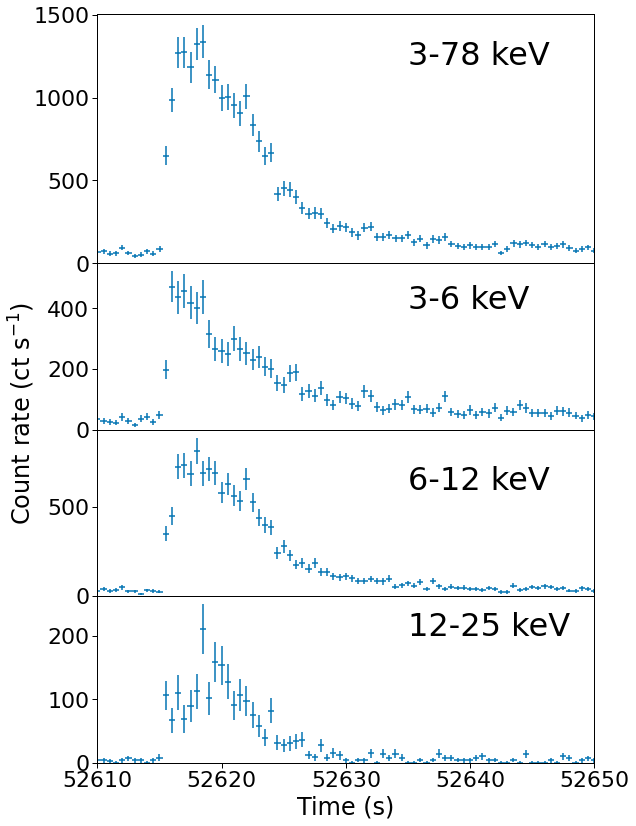

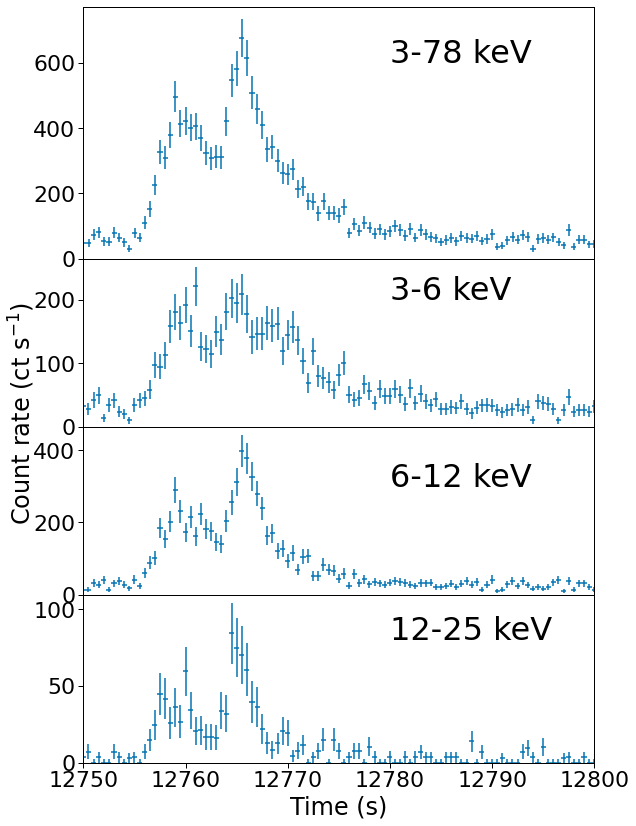

In [10]:
curveA_low = bkg_subtract(nuproducts_to_stingray_lc(root_dir + 'products_3to6keV/' + 'nu90601317002A01_sr.lc'), nuproducts_to_stingray_lc(root_dir + 'products_3to6keV/' + 'nu90601317002A01_bk.lc'))
curveB_low = bkg_subtract(nuproducts_to_stingray_lc(root_dir + 'products_3to6keV/' + 'nu90601317002B01_sr.lc'), nuproducts_to_stingray_lc(root_dir + 'products_3to6keV/' + 'nu90601317002B01_bk.lc'))
curve_total_low = sum_lc(curveA_low, curveB_low)

curveA_mid = bkg_subtract(nuproducts_to_stingray_lc(root_dir + 'products_6to12keV/' + 'nu90601317002A01_sr.lc'), nuproducts_to_stingray_lc(root_dir + 'products_6to12keV/' + 'nu90601317002A01_bk.lc'))
curveB_mid = bkg_subtract(nuproducts_to_stingray_lc(root_dir + 'products_6to12keV/' + 'nu90601317002B01_sr.lc'), nuproducts_to_stingray_lc(root_dir + 'products_6to12keV/' + 'nu90601317002B01_bk.lc'))
curve_total_mid = sum_lc(curveA_mid, curveB_mid)

curveA_hi = bkg_subtract(nuproducts_to_stingray_lc(root_dir + 'products_12to25keV/' + 'nu90601317002A01_sr.lc'), nuproducts_to_stingray_lc(root_dir + 'products_12to25keV/' + 'nu90601317002A01_bk.lc'))
curveB_hi = bkg_subtract(nuproducts_to_stingray_lc(root_dir + 'products_12to25keV/' + 'nu90601317002B01_sr.lc'), nuproducts_to_stingray_lc(root_dir + 'products_12to25keV/' + 'nu90601317002B01_bk.lc'))
curve_total_hi = sum_lc(curveA_hi, curveB_hi)

sns.set_context('paper', font_scale=2.5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(9,12), sharex=True, gridspec_kw = {'height_ratios':[1.5, 1,1,1], 'hspace':0})
ax1.errorbar(curve_total.time-t_start, curve_total.countrate, xerr=curve_total.dt/2., yerr=curve_total.countrate_err, fmt='none', lw = 1.5)
ax2.errorbar(curve_total_low.time-t_start, curve_total_low.countrate, xerr=curve_total_low.dt/2., yerr=curve_total_low.countrate_err, fmt='none', lw = 1.5)
ax3.errorbar(curve_total_mid.time-t_start, curve_total_mid.countrate, xerr=curve_total_mid.dt/2., yerr=curve_total_mid.countrate_err, fmt='none', lw = 1.5)
ax4.errorbar(curve_total_hi.time-t_start, curve_total_hi.countrate, xerr=curve_total_hi.dt/2., yerr=curve_total_hi.countrate_err, fmt='none', lw = 1.5)

ax1.text(52635, 1200, '3-78 keV', fontsize=32)
ax2.text(52635, 400, '3-6 keV', fontsize=32)
ax3.text(52635, 600, '6-12 keV', fontsize=32)
ax4.text(52635, 200, '12-25 keV', fontsize=32)

ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax3.set_ylim(bottom=0)
ax4.set_ylim(bottom=0)

fig.text(0, 0.5, str(r'$\mathrm{Count\ rate\ (ct\ s^{-1})}$'), va='center', rotation='vertical')

# ax1.set_ylabel(r'$\mathrm{Count\ rate\ (ct\ s^{-1})}$')
# ax2.set_ylabel(r'$\mathrm{Count\ rate\ (ct\ s^{-1})}$')
# ax3.set_ylabel(r'$\mathrm{Count\ rate\ (ct\ s^{-1})}$')
# ax4.set_ylabel(r'$\mathrm{Count\ rate\ (ct\ s^{-1})}$')

ax4.set_xlabel('Time (s)')

ax4.set_xlim((52610,52650))
plt.tight_layout()

plt.savefig(plot_dir + 'burst2_profile_energysplit.pdf')


fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(9,12), sharex=True, gridspec_kw = {'height_ratios':[1.5, 1,1,1], 'hspace':0})
ax1.errorbar(curve_total.time[:50000]-t_start, curve_total.countrate[:50000], xerr=curve_total.dt/2., yerr=curve_total.countrate_err[:50000], fmt='none', lw = 1.5)
ax2.errorbar(curve_total_low.time[:50000]-t_start, curve_total_low.countrate[:50000], xerr=curve_total_low.dt/2., yerr=curve_total_low.countrate_err[:50000], fmt='none', lw = 1.5)
ax3.errorbar(curve_total_mid.time[:50000]-t_start, curve_total_mid.countrate[:50000], xerr=curve_total_mid.dt/2., yerr=curve_total_mid.countrate_err[:50000], fmt='none', lw = 1.5)
ax4.errorbar(curve_total_hi.time[:50000]-t_start, curve_total_hi.countrate[:50000], xerr=curve_total_hi.dt/2., yerr=curve_total_hi.countrate_err[:50000], fmt='none', lw = 1.5)

ax1.text(12780, 600, '3-78 keV', fontsize=32)
ax2.text(12780, 200, '3-6 keV', fontsize=32)
ax3.text(12780, 300, '6-12 keV', fontsize=32)
ax4.text(12780, 80, '12-25 keV', fontsize=32)

ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax3.set_ylim(bottom=0)
ax4.set_ylim(bottom=0)

fig.text(0, 0.5, str(r'$\mathrm{Count\ rate\ (ct\ s^{-1})}$'), va='center', rotation='vertical')

# ax1.set_ylabel(r'$\mathrm{Count\ rate\ (ct\ s^{-1})}$')
# ax2.set_ylabel(r'$\mathrm{Count\ rate\ (ct\ s^{-1})}$')
# ax3.set_ylabel(r'$\mathrm{Count\ rate\ (ct\ s^{-1})}$')
# ax4.set_ylabel(r'$\mathrm{Count\ rate\ (ct\ s^{-1})}$')

ax4.set_xlabel('Time (s)')

ax4.set_xlim((12750,12800))
plt.tight_layout()

plt.savefig(plot_dir + 'burst1_profile_energysplit.pdf')


# plt.figure(figsize = (6,6))
# plt.errorbar(curve_total.time[:50000]-t_start, curve_total.countrate[:50000], xerr=curve_total.dt/2., yerr=curve_total.countrate_err[:50000], fmt='none', lw = 1.0)
# plt.xlabel('Time (s)')
# plt.ylabel(r'$\mathrm{3-78\ keV\ rate\ (ct\ s^{-1})}$')

# plt.xlim((12750,12800))
# plt.tight_layout()

# plt.savefig(plot_dir + 'burst1_profile.pdf')


# plt.figure(figsize = (6,6))
# plt.errorbar(curve_total.time-t_start, curve_total.countrate, xerr=curve_total.dt/2., yerr=curve_total.countrate_err, fmt='none', lw = 1.0)
# plt.xlabel('Time (s)')
# plt.ylabel(r'$\mathrm{3-78\ keV\ rate\ (ct\ s^{-1})}$')


# plt.xlim((52610,52650))
# plt.tight_layout()

# plt.savefig(plot_dir + 'burst2_profile.pdf')


In [8]:
sns.set_context('paper', font_scale=2.5)
burst1_mask = ((curve_total.time-t_start) > 12000) * ((curve_total.time-t_start) < 15000)
burst2_mask = ((curve_total.time-t_start) > 52000) * ((curve_total.time-t_start) < 56000)

popt1, pcov1 = scipy.optimize.curve_fit(FRED, (curve_total.time-t_start)[burst1_mask], curve_total.countrate[burst1_mask], \
                                      p0 = [12750., 15., 0.5, 400., 100.], sigma = curve_total.countrate_err[burst1_mask], \
                                       bounds = np.array([[12000., 15000], [0., np.inf], [0., np.inf], [0.0, np.inf], [0., np.inf]]).T)

chisq1 = np.sum(np.square((curve_total.countrate[burst1_mask]-FRED((curve_total.time-t_start)[burst1_mask], *popt1))/curve_total.countrate_err[burst1_mask]))

popt2, pcov2 = scipy.optimize.curve_fit(FRED, (curve_total.time-t_start)[burst2_mask], curve_total.countrate[burst2_mask], \
                                      p0 = [52620., 15., 1.0, 400., 12.], sigma = curve_total.countrate_err[burst2_mask], \
                                       bounds = np.array([[52000., 56000], [0., np.inf], [0., np.inf], [0.0, np.inf], [0., np.inf]]).T)

chisq2 = np.sum(np.square((curve_total.countrate[burst2_mask]-FRED((curve_total.time-t_start)[burst2_mask], *popt2))/curve_total.countrate_err[burst2_mask]))


# popt1, pcov1 = scipy.optimize.curve_fit(FRED_plateau, (curveA.time-t_start)[burst1_mask], curveA.countrate[burst1_mask], \
#                                       p0 = [24150., 10., 15., 0.5, 400., 100.], sigma = curveA.countrate_err[burst1_mask], \
#                                        bounds = np.array([[24000., 24250], [3., np.inf], [0., np.inf], [0., np.inf], [0.0, np.inf], [0., np.inf]]).T)

# popt2, pcov2 = scipy.optimize.curve_fit(FRED_plateau, (curveA.time-t_start)[burst2_mask], curveA.countrate[burst2_mask], \
#                                       p0 = [37880., 10., 15., 0.5, 400., 12.], sigma = curveA.countrate_err[burst2_mask], \
#                                        bounds = np.array([[37800., 38000], [3., np.inf], [0., np.inf], [0., np.inf], [0.0, np.inf], [0., np.inf]]).T)

# print(popt1)
# print(popt2)

# plt.figure(figsize = (9,6))
# plt.errorbar(curve_total.time-t_start, curve_total.countrate, xerr=curve_total.dt/2., yerr=curve_total.countrate_err, fmt='none', lw = 0.5)
# plt.plot((curve_total.time-t_start)[burst1_mask], FRED((curve_total.time-t_start)[burst1_mask], *popt1))
# plt.plot((curve_total.time-t_start)[burst2_mask], FRED((curve_total.time-t_start)[burst2_mask], *popt2))
# plt.xlabel('Time (s)')
# plt.ylabel('FPMA count rate')
# # plt.close()

# plt.figure(figsize=(9,6))
# tmp_start = popt1[0] - 10.
# tmp_mask = ((curve_total.time-t_start) > tmp_start) * ((curve_total.time-t_start) < ((popt1[0]) + (100.*popt1[1])))

# plt.errorbar((curve_total.time-t_start)[tmp_mask] - tmp_start, curve_total.countrate[tmp_mask], xerr=curve_total.dt/2., yerr=curve_total.countrate_err[tmp_mask], fmt='none', lw = 1)
# plt.yscale('log')
# plt.xlim(8.,200.)
# plt.xscale('log')
# plt.ylabel(r'$\mathrm{3-78\ keV\ rate\ (ct\ s^{-1})}$')
# plt.tight_layout()
# plt.savefig(plot_dir + 'burst1_profile_log.pdf')


# plt.figure(figsize=(9,6))
# tmp_start = popt2[0] - 10.
# tmp_mask = ((curve_total.time-t_start) > tmp_start) * ((curve_total.time-t_start) < ((popt2[0]) + (100.*popt2[1])))

# plt.errorbar((curve_total.time-t_start)[tmp_mask] - tmp_start, curve_total.countrate[tmp_mask], xerr=curve_total.dt/2., yerr=curve_total.countrate_err[tmp_mask], fmt='none', lw = 1)
# plt.yscale('log')
# plt.xlim(8.,200.)
# plt.xscale('log')
# plt.ylabel(r'$\mathrm{3-78\ keV\ rate\ (ct\ s^{-1})}$')
# plt.tight_layout()
# plt.savefig(plot_dir + 'burst2_profile_log.pdf')

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9,9), sharex=True, gridspec_kw = {'height_ratios':[2,1], 'hspace':0})
# tmp_start = (popt1[0] + np.sqrt(popt1[1]*popt1[2])) - 10.
tmp_start = popt1[0] - 10.
tmp_mask = ((curve_total.time-t_start) > tmp_start) * ((curve_total.time-t_start) < ((popt1[0]) + (100.*popt1[1])))
model_t = np.linspace(((curve_total.time-t_start)[tmp_mask])[0], ((curve_total.time-t_start)[tmp_mask])[-1], 50000)

ax1.errorbar((curve_total.time-t_start)[tmp_mask] - tmp_start, curve_total.countrate[tmp_mask], xerr=curve_total.dt/2., yerr=curve_total.countrate_err[tmp_mask], fmt='none', lw = 1)
ax1.plot(model_t - tmp_start, FRED(model_t, *popt1), color='C1', lw=2)
ax2.errorbar((curve_total.time-t_start)[tmp_mask] - tmp_start, (curve_total.countrate[tmp_mask]-FRED((curve_total.time-t_start)[tmp_mask], *popt1))/curve_total.countrate_err[tmp_mask], xerr=curve_total.dt/2., yerr=1.0, fmt='none', lw = 1)
ax2.axhline(0.0)
ax1.set_yscale('log')
ax1.set_ylim(20.,900.)
ax1.set_xlim(8.,200.)
ax1.set_xscale('log')
ax2.set_xlabel(r'$t-t_0+10\ (\mathrm{s})$')
# ax2.set_ylabel(r'$\frac{data-model}{error}$')
ax2.set_ylabel(r'$\chi$')
ax1.set_ylabel(r'$\mathrm{3-78\ keV\ rate\ (ct\ s^{-1})}$')
plt.tight_layout()
plt.savefig(plot_dir + 'burst1_profile_FRED.pdf')
plt.close()


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9,9), sharex=True, gridspec_kw = {'height_ratios':[2,1], 'hspace':0})
# tmp_start = (popt1[0] + np.sqrt(popt1[1]*popt1[2])) - 10.
tmp_start = popt2[0] - 10.
tmp_mask = ((curve_total.time-t_start) > tmp_start) * ((curve_total.time-t_start) < ((popt2[0]) + (100.*popt2[1])))
model_t = np.linspace(((curve_total.time-t_start)[tmp_mask])[0], ((curve_total.time-t_start)[tmp_mask])[-1], 50000)

ax1.errorbar((curve_total.time-t_start)[tmp_mask] - tmp_start, curve_total.countrate[tmp_mask], xerr=curve_total.dt/2., yerr=curve_total.countrate_err[tmp_mask], fmt='none', lw = 1)

ax1.plot(model_t - tmp_start, FRED(model_t, *popt2), color='C2', lw=2)

ax2.errorbar((curve_total.time-t_start)[tmp_mask] - tmp_start, (curve_total.countrate[tmp_mask]-FRED((curve_total.time-t_start)[tmp_mask], *popt2))/curve_total.countrate_err[tmp_mask], xerr=curve_total.dt/2., yerr=1.0, fmt='none', lw = 1)
ax2.axhline(0.0)
ax1.set_yscale('log')
ax1.set_xlim(8.,200.)
ax1.set_ylim(30.,2000.)
ax1.set_xscale('log')
ax2.set_xlabel(r'$t-t_0+10\ (\mathrm{s})$')
# ax2.set_ylabel(r'$\frac{data-model}{error}$')
ax2.set_ylabel(r'$\chi$')
ax1.set_ylabel(r'$\mathrm{3-78\ keV\ rate\ (ct\ s^{-1})}$')
plt.tight_layout()
plt.savefig(plot_dir + 'burst2_profile_FRED.pdf')
plt.close()

print(popt1)
print(chisq1/np.sum(burst1_mask))
print(popt2)
print(chisq2/np.sum(burst2_mask))
sns.set_context('paper', font_scale=1.5)

[1.27520274e+04 5.25042419e+00 1.86821323e+01 1.73812500e+04
 4.42384784e+01]
1.0833896783954302
[5.26149367e+04 5.86718253e+00 8.04166038e-01 2.60353206e+03
 5.76560820e+01]
1.0565926385589033


[1.27638511e+04 5.90363067e+00 1.70759596e-01 5.56063155e+02
 1.27524742e+04 2.32446950e+00 2.32101956e+01 2.14046781e+05
 4.42519386e+01]
[1.44041090e-01 4.04873036e-01 1.70307157e-01 1.05741814e+02
 1.42116178e+00 7.92686956e-01 1.72307331e+01 7.33479613e+05
 1.68983863e-01]


1.0040426239290916
0.5018734817668603
7.3451611152785885
3.00033944550921


395.7322148607441
100.9457543699015
385.3259836159246
1653.166431897845


[5.26146617e+04 4.87619283e+00 1.56668563e+00 4.03152476e+03
 1.60915439e+00 1.74198766e+01 5.70927305e+01]
[6.52215536e-02 1.73240666e-01 2.11060411e-01 3.97139647e+02
 9.99546557e-02 8.73722317e-01 1.99655513e-01]


2.763957528094401
0.19254247147215664
1297.56671263368
163.8256123111639


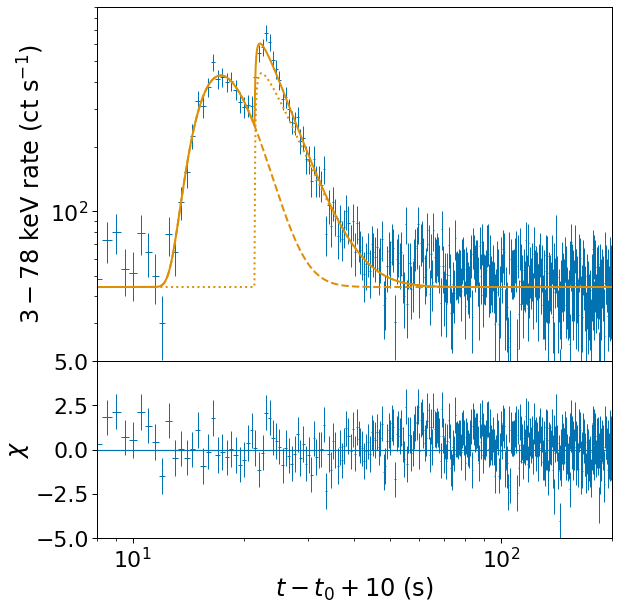

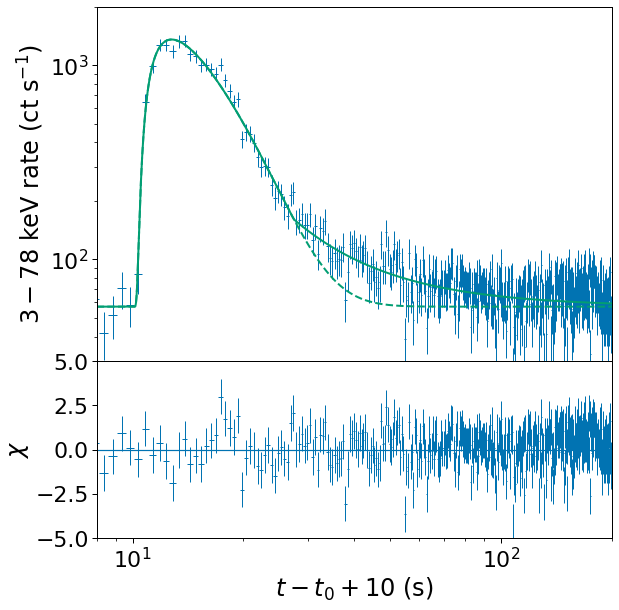

In [9]:
popt1, pcov1 = scipy.optimize.curve_fit(FRED_2, (curve_total.time-t_start)[burst1_mask], curve_total.countrate[burst1_mask], \
                                      p0 = [12750., 5., 1., 10000., 12765., 5., 1., 10000., 150.], sigma = curve_total.countrate_err[burst1_mask], \
                                       bounds = np.array([[12000., 15000], [0., np.inf], [0., np.inf], [0.0, np.inf], [12000., 15000], [0., np.inf], [0., np.inf], [0.0, np.inf], [0., np.inf]]).T)

chisq1 = np.sum(np.square((curve_total.countrate[burst1_mask]-FRED_2((curve_total.time-t_start)[burst1_mask], *popt1))/curve_total.countrate_err[burst1_mask]))

# popt2, pcov2 = scipy.optimize.curve_fit(FRED_plateau, (curve_total.time-t_start)[burst2_mask], curve_total.countrate[burst2_mask], \
#                                       p0 = [52614., 5., 1., 2., 1000., 150.], sigma = curve_total.countrate_err[burst2_mask], \
#                                        bounds = np.array([[52000., 56000], [0., np.inf], [0., np.inf], [0.0, np.inf], [0., np.inf], [0., np.inf]]).T)

# popt2, pcov2 = scipy.optimize.curve_fit(FRED_powerlaw, (curve_total.time-t_start)[burst2_mask], curve_total.countrate[burst2_mask], \
#                                       p0 = [52614., 5., 1., 3000., 10., 0.1, 60.], sigma = curve_total.countrate_err[burst2_mask], \
#                                        bounds = np.array([[52000., 56000], [0., np.inf], [0.0, np.inf], [0., np.inf],[0.0, np.inf], [0., np.inf], [0., np.inf]]).T)

popt2, pcov2 = scipy.optimize.curve_fit(FRED_powerlaw, (curve_total.time-t_start)[burst2_mask], curve_total.countrate[burst2_mask], \
                                      p0 = [52614., 5., 1., 3000., 1.0, 25., 60.], sigma = curve_total.countrate_err[burst2_mask], \
                                       bounds = np.array([[52000., 56000], [0.0, np.inf], [0., np.inf], [0., np.inf], [0., np.inf], [0., np.inf], [0., np.inf]]).T)

chisq2 = np.sum(np.square((curve_total.countrate[burst2_mask]-FRED_powerlaw((curve_total.time-t_start)[burst2_mask], *popt2))/curve_total.countrate_err[burst2_mask]))

sns.set_context('paper', font_scale=2.5)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9,9), sharex=True, gridspec_kw = {'height_ratios':[2,1], 'hspace':0})
# tmp_start = (popt1[0] + np.sqrt(popt1[1]*popt1[2])) - 10.
tmp_start = np.min([popt1[0], popt1[4]]) - 10.
tmp_mask = ((curve_total.time-t_start) > tmp_start) * ((curve_total.time-t_start) < (np.min([popt1[0], popt1[4]]) + (100.*np.max([popt1[1], popt1[5]]))))
ax1.errorbar((curve_total.time-t_start)[tmp_mask] - tmp_start, curve_total.countrate[tmp_mask], xerr=curve_total.dt/2., yerr=curve_total.countrate_err[tmp_mask], fmt='none', lw = 1)

model_t = np.linspace(((curve_total.time-t_start)[tmp_mask])[0], ((curve_total.time-t_start)[tmp_mask])[-1], 50000)
ax1.plot(model_t-tmp_start, FRED_2(model_t, *popt1), color='C1', lw=2)
ax1.plot(model_t-tmp_start, FRED(model_t, *([*popt1[:4], popt1[-1]])), color='C1', ls='dotted', lw=2)
ax1.plot(model_t-tmp_start, FRED(model_t, *(popt1[4:])), color='C1', ls='dashed', lw=2)

ax2.errorbar((curve_total.time-t_start)[tmp_mask] - tmp_start, (curve_total.countrate[tmp_mask]-FRED_2((curve_total.time-t_start)[tmp_mask], *popt1))/curve_total.countrate_err[tmp_mask], xerr=curve_total.dt/2., yerr=1.0, fmt='none', lw = 1)

ax2.axhline(0.0)
ax1.set_yscale('log')
ax1.set_xlim(8.,200.)
ax1.set_ylim(20.,900.)
ax1.set_xscale('log')
ax2.set_xlabel(r'$t-t_0+10\ (\mathrm{s})$')
# ax2.set_ylabel(r'$\frac{data-model}{error}$')
ax2.set_ylabel(r'$\chi$')
ax2.set_ylim(-5.,5.)
ax1.set_ylabel(r'$\mathrm{3-78\ keV\ rate\ (ct\ s^{-1})}$')
plt.tight_layout()
plt.savefig(plot_dir + 'burst1_profile_twopeaks.pdf')


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9,9), sharex=True, gridspec_kw = {'height_ratios':[2,1], 'hspace':0})
# tmp_start = (popt2[0] + np.sqrt(popt2[1]*popt2[2])) - 10.
tmp_start = popt2[0] - 10.
tmp_mask = ((curve_total.time-t_start) > tmp_start) * ((curve_total.time-t_start) < (popt2[0] + 100.*popt2[1]))
ax1.errorbar((curve_total.time-t_start)[tmp_mask] - tmp_start, curve_total.countrate[tmp_mask], xerr=curve_total.dt/2., yerr=curve_total.countrate_err[tmp_mask], fmt='none', lw = 1)

model_t = np.linspace(((curve_total.time-t_start)[tmp_mask])[0], ((curve_total.time-t_start)[tmp_mask])[-1], 50000)
ax1.plot(model_t-tmp_start, FRED_powerlaw(model_t, *popt2), color='C2', lw=2)
ax1.plot(model_t-tmp_start, FRED(model_t, *([*popt2[:4], popt2[-1]])), color='C2', ls='dashed', lw=2)
# ax1.plot(model_t-tmp_start, powerlaw_tail(model_t, *popt2), color='C2', ls='dotted', lw=2)

ax2.errorbar((curve_total.time-t_start)[tmp_mask] - tmp_start, (curve_total.countrate[tmp_mask]-FRED_powerlaw((curve_total.time-t_start)[tmp_mask], *popt2))/curve_total.countrate_err[tmp_mask], xerr=curve_total.dt/2., yerr=1.0, fmt='none', lw = 1)


ax2.axhline(0.0)
ax1.set_yscale('log')
ax1.set_xlim(8.,200.)
ax1.set_ylim(30.,2000.)
ax1.set_xscale('log')
ax2.set_xlabel(r'$t-t_0+10\ (\mathrm{s})$')
# ax2.set_ylabel(r'$\frac{data-model}{error}$')
ax2.set_ylabel(r'$\chi$')
ax2.set_ylim(-5.,5.)
ax1.set_ylabel(r'$\mathrm{3-78\ keV\ rate\ (ct\ s^{-1})}$')
plt.tight_layout()
plt.savefig(plot_dir + 'burst2_profile_pl.pdf')


print(popt1)
print(np.sqrt(np.diag(pcov1)))
print('\n')
print(np.sqrt(popt1[1]*popt1[2]))
print(0.5*np.sqrt((np.diag(pcov1)[2]*popt1[1]/popt1[2]) + np.diag(pcov1)[1]*popt1[2]/popt1[1]))
print(np.sqrt(popt1[5]*popt1[6]))
print(0.5*np.sqrt((np.diag(pcov1)[6]*popt1[5]/popt1[6]) + np.diag(pcov1)[5]*popt1[6]/popt1[5]))
print('\n')
print(popt1[3]*np.exp(-2*np.sqrt(popt1[2]/popt1[1])))
print(popt1[3]*np.exp(-2*np.sqrt(popt1[2]/popt1[1])) * \
      np.sqrt((np.diag(pcov1)[3]/np.square(popt1[3])) +(np.diag(pcov1)[2]/(popt1[1]*popt1[2])) + (np.diag(pcov1)[1]*popt1[2]/np.power(popt1[1], 3))))
print(popt1[7]*np.exp(-2*np.sqrt(popt1[6]/popt1[5])))
print(popt1[7]*np.exp(-2*np.sqrt(popt1[6]/popt1[5])) * \
      np.sqrt((np.diag(pcov1)[7]/np.square(popt1[7])) +(np.diag(pcov1)[6]/(popt1[5]*popt1[6])) + (np.diag(pcov1)[5]*popt1[6]/np.power(popt1[5], 3))))

# print(chisq1/np.sum(burst1_mask))
print('\n')
print(popt2)
print(np.sqrt(np.diag(pcov2)))
print('\n')
print(np.sqrt(popt2[1]*popt2[2]))
print(0.5*np.sqrt((np.diag(pcov2)[2]*popt2[1]/popt2[2]) + np.diag(pcov2)[1]*popt2[2]/popt2[1]))
print(popt2[3]*np.exp(-2*np.sqrt(popt2[2]/popt2[1])))
print(popt2[3]*np.exp(-2*np.sqrt(popt2[2]/popt2[1])) * \
      np.sqrt((np.diag(pcov2)[3]/np.square(popt2[3])) +(np.diag(pcov2)[2]/(popt2[1]*popt2[2])) + (np.diag(pcov2)[1]*popt2[2]/np.power(popt2[1], 3))))


In [8]:
print(4*np.argmax([popt1[0], popt1[4]]))
print(popt1[(4*np.argmax([popt1[0], popt1[4]]))+1])
burst1_gti = [np.min([popt1[0], popt1[4]]) + t_start, np.max([popt1[0], popt1[4]]) + 5.*popt1[(4*np.argmax([popt1[0], popt1[4]]))+1] + t_start]
burst2_gti = [popt2[0] + t_start, popt2[0] + 5.*popt2[1] + t_start]

print(burst1_gti[1]-burst1_gti[0])
print(burst2_gti[1]-burst2_gti[0])

# persistent_gti = sting_gti.cross_two_gtis([[t_start-10., burst1_gti[0]-100],[burst1_gti[1]+500, burst2_gti[0]-100], [burst2_gti[1]+500, np.max(curve_total.time) + 10.]], \
#                                           curve_total.gti)

# persistent_gti_part1 = sting_gti.cross_two_gtis([[t_start-10., burst1_gti[0]-100.], [burst1_gti[1]+500., t_start + 15000.]], \
#                                           curve_total.gti)

# persistent_gti_part2 = sting_gti.cross_two_gtis([[burst2_gti[0] - 15000., burst2_gti[0]-100.], [burst2_gti[1]+500., np.max(curve_total.time) + 10.]], \
#                                           curve_total.gti)

# print(persistent_gti)
# print(persistent_gti_part1)
# print(persistent_gti_part2)

0
5.903630405650269
40.89498072862625
24.38096421957016


In [9]:
primary_hdr = fits.Header()
primary_hdr['HDUCLASS'] = 'OGIP'
primary_hdr['HDUDOC'] = 'OGIP/92-009'
primary_hdu = fits.PrimaryHDU(header=primary_hdr)

gti_hdr = fits.Header()
gti_hdr['HDUCLASS'] = 'OGIP'
gti_hdr['EXTNAME'] = 'GTI'
c1 = fits.Column(name='START', array=[burst1_gti[0]], format='D')
c2 = fits.Column(name='STOP', array=[burst1_gti[1]], format='D')
gti_hdu = fits.BinTableHDU.from_columns([c1, c2], header = gti_hdr)

hdul = fits.HDUList([primary_hdu, gti_hdu])
hdul.writeto(root_dir+'burst1/' + 'burst1_gti_bc.fits', overwrite=True)

##################################

primary_hdr = fits.Header()
primary_hdr['HDUCLASS'] = 'OGIP'
primary_hdr['HDUDOC'] = 'OGIP/92-009'
primary_hdu = fits.PrimaryHDU(header=primary_hdr)

gti_hdr = fits.Header()
gti_hdr['HDUCLASS'] = 'OGIP'
gti_hdr['EXTNAME'] = 'GTI'
c1 = fits.Column(name='START', array=[burst2_gti[0]], format='D')
c2 = fits.Column(name='STOP', array=[burst2_gti[1]], format='D')
gti_hdu = fits.BinTableHDU.from_columns([c1, c2], header = gti_hdr)

hdul = fits.HDUList([primary_hdu, gti_hdu])
hdul.writeto(root_dir + 'burst2/' +'burst2_gti_bc.fits', overwrite=True)

##################################

# short_gtis_1 = np.array([4.0, *[2.0 for i in range(7)], *np.logspace(np.log10(4.0), 2, 7)])
# print(len(short_gtis_1))
# print(sum(short_gtis_1))

# print(short_gtis_1)

# for i, x in enumerate(short_gtis_1):
#     temp_gti = [burst1_gti[0] + np.sum(short_gtis_1[:i]), burst1_gti[0] + np.sum(short_gtis_1[:i+1])]
#     print(temp_gti)
#     primary_hdr = fits.Header()
#     primary_hdr['HDUCLASS'] = 'OGIP'
#     primary_hdr['HDUDOC'] = 'OGIP/92-009'
#     primary_hdu = fits.PrimaryHDU(header=primary_hdr)

#     gti_hdr = fits.Header()
#     gti_hdr['HDUCLASS'] = 'OGIP'
#     gti_hdr['EXTNAME'] = 'GTI'
#     c1 = fits.Column(name='START', array=[temp_gti[0]], format='D')
#     c2 = fits.Column(name='STOP', array=[temp_gti[1]], format='D')
#     gti_hdu = fits.BinTableHDU.from_columns([c1, c2], header = gti_hdr)

#     hdul = fits.HDUList([primary_hdu, gti_hdu])
#     hdul.writeto(root_dir + 'burst1/gtis/' +'burst1_seg' + str(i) + '_gti.fits', overwrite=True)
    
# short_gtis_2 = np.array([*[1.0 for i in range(10)], *np.logspace(0, 2, 10)])
# print(len(short_gtis_2))
# print(sum(short_gtis_2))
    
# for i, x in enumerate(short_gtis_2[:-1]):
#     temp_gti = [burst2_gti[0] + np.sum(short_gtis_2[:i]), burst2_gti[0] + np.sum(short_gtis_2[:i+1])]
#     print(temp_gti)
#     primary_hdr = fits.Header()
#     primary_hdr['HDUCLASS'] = 'OGIP'
#     primary_hdr['HDUDOC'] = 'OGIP/92-009'
#     primary_hdu = fits.PrimaryHDU(header=primary_hdr)

#     gti_hdr = fits.Header()
#     gti_hdr['HDUCLASS'] = 'OGIP'
#     gti_hdr['EXTNAME'] = 'GTI'
#     c1 = fits.Column(name='START', array=[temp_gti[0]], format='D')
#     c2 = fits.Column(name='STOP', array=[temp_gti[1]], format='D')
#     gti_hdu = fits.BinTableHDU.from_columns([c1, c2], header = gti_hdr)

#     hdul = fits.HDUList([primary_hdu, gti_hdu])
#     hdul.writeto(root_dir + 'burst2/gtis/' + 'burst2_seg' + str(i) + '_gti.fits', overwrite=True)



In [10]:
log_area = 45.768

stef_boltz_cgs = 5.6704E-5
boltz_keV = 8.6173E-8

L_const = (49/25) * np.pi*stef_boltz_cgs*1.0E10/np.power(boltz_keV, 4)

PRE_data1 = np.loadtxt('/Users/sean/Desktop/GRS_PRE/Burst 1-opt-Table 1.csv', delimiter=',', dtype=str)[1:]
PRE_data2 = np.loadtxt('/Users/sean/Desktop/GRS_PRE/Burst 2-opt-Table 1.csv', delimiter=',', dtype=str)[1:]

PRE_data1[PRE_data1==''] = np.inf
PRE_data2[PRE_data2==''] = np.inf

PRE_data1 = PRE_data1.astype(float)
PRE_data2 = PRE_data2.astype(float)

In [11]:
burst1_times = np.cumsum(short_gtis_1)-short_gtis_1/2
burst2_times = np.cumsum(short_gtis_2)-short_gtis_2/2

PRE_ind1 = []
for i in range(len(PRE_data1)):
    if np.inf not in PRE_data1[i]:
        PRE_ind1.append(i)
PRE_ind1 = np.array(PRE_ind1)
        
PRE_ind2 = []
for i in range(len(PRE_data2)):
    if np.inf not in PRE_data2[i]:
        PRE_ind2.append(i)
PRE_ind2 = np.array(PRE_ind2)


[1.25138228e+37 2.55340674e+37 2.06761655e+37 1.71968934e+37
 3.17241504e+37 2.55381833e+37 1.62584822e+37 1.10664927e+37
 4.27848486e+36]
[2.29587  1.94904  1.72034  1.6428   2.12179  2.06425  1.4861   1.3042
 0.848942]


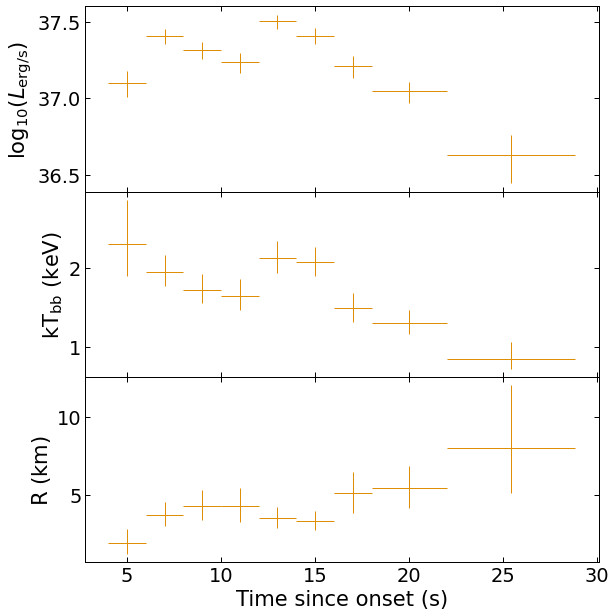

In [17]:
kT = PRE_data1[PRE_ind1].T[4]
kT_minus = PRE_data1[PRE_ind1].T[5]
kT_plus = PRE_data1[PRE_ind1].T[6]

logbbFlux = PRE_data1[PRE_ind1].T[1]
logbbFlux_minus = PRE_data1[PRE_ind1].T[2]
logbbFlux_plus = PRE_data1[PRE_ind1].T[3]

L_D72 = log_area + logbbFlux
L_err_minus = logbbFlux_minus
L_err_plus = logbbFlux_plus

print(np.power(10, L_D72))
print(kT)

log_Rkm_D7 = (logbbFlux - 4*np.log10(kT) - np.log10(stef_boltz_cgs/(np.power(boltz_keV, 4)*4.6656E+34)))/2
Rkm_D7 = np.power(10, log_Rkm_D7)
Rkm_D7_minus = (Rkm_D7/np.log10(np.e)) * np.sqrt(np.square(logbbFlux_minus/2) + np.square(2*np.log10(np.e)*kT_minus/kT))
Rkm_D7_plus = (Rkm_D7/np.log10(np.e)) * np.sqrt(np.square(logbbFlux_plus/2) + np.square(2*np.log10(np.e)*kT_plus/kT))

sns.set_context('paper', font_scale=2.2)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(9,9), sharex=True, gridspec_kw = {'height_ratios':[1,1,1], 'hspace':0})

ax2.errorbar(burst1_times[PRE_ind1], kT, xerr=short_gtis_1[PRE_ind1]/2, \
             yerr=(kT_minus, kT_plus), fmt='none', lw=1.0, color='C1')

ax1.errorbar(burst1_times[PRE_ind1], L_D72, xerr=short_gtis_1[PRE_ind1]/2, \
             yerr=(L_err_minus, L_err_plus), fmt='none', lw=1.0, color='C1')

ax3.errorbar(burst1_times[PRE_ind1], Rkm_D7, xerr=short_gtis_1[PRE_ind1]/2, \
             yerr=(Rkm_D7_minus, Rkm_D7_plus), fmt='none', lw=1.0, color='C1')

ax2.set_ylabel(r'$\mathrm{kT_{bb}\ (keV)}$')
ax1.set_ylabel(r'$\log_{10}(L_{\mathrm{erg/s}})$')
ax3.set_ylabel(r'$\mathrm{R\ (km)}$')
ax3.set_xlabel('Time since onset (s)')

ax1.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax2.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax3.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)

plt.tight_layout()

plt.savefig(plot_dir+'burst1_PRE.pdf')



9.53432605822651e-09
5.588432375647147e+37
[5.02751907 5.14968942 4.21589983 3.40523013 3.52346738 3.11600587
 3.48454993 3.48928423 3.46390673 3.16280572 3.91041065 3.96318438
 4.97148692 5.88297348 5.04211565 2.75739346 1.5957168  1.60415595
 1.50959553]
[  1.5          2.5          3.5          4.5          5.5
   6.5          7.5          8.5          9.5         10.5
  11.83405027  14.05938024  17.77145436  23.96356719  34.29263392
  51.5225557   80.26379747 128.2070783  208.18129082]
[1.92978 1.94029 2.22112 2.39079 2.29134 2.46813 2.30076 2.23614 2.14222
 1.99722 1.79481 1.64914 1.3648  1.09868 1.05903 1.20512 1.33059 1.25709
 1.37302]


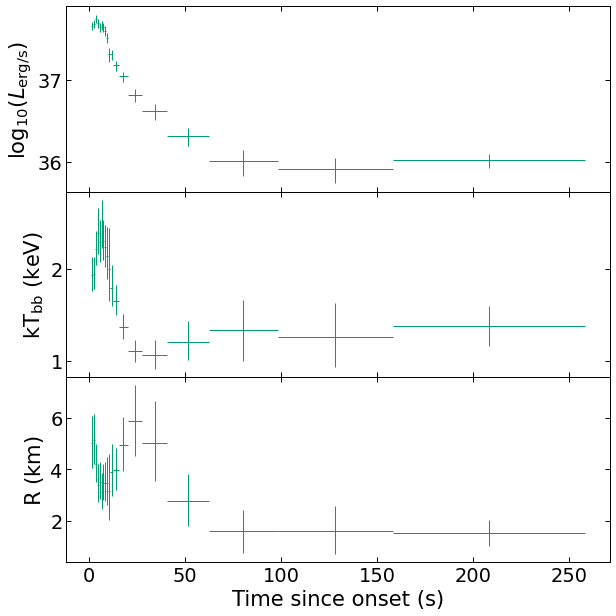

In [16]:
kT = PRE_data2[PRE_ind2].T[4]
kT_minus = PRE_data2[PRE_ind2].T[5]
kT_plus = PRE_data2[PRE_ind2].T[6]

logbbFlux = PRE_data2[PRE_ind2].T[1]
logbbFlux_minus = PRE_data2[PRE_ind2].T[2]
logbbFlux_plus = PRE_data2[PRE_ind2].T[3]

L_D72 = log_area + logbbFlux
L_err_minus = logbbFlux_minus
L_err_plus = logbbFlux_plus

log_Rkm_D7 = (logbbFlux - 4*np.log10(kT) - np.log10(stef_boltz_cgs/(np.power(boltz_keV, 4)*4.6656E+34)))/2
log_Rkm_D7_minus = np.sqrt(np.square(logbbFlux_minus/2) + np.square(2*np.log10(np.e)*kT_minus/kT))
log_Rkm_D7_plus = np.sqrt(np.square(logbbFlux_plus/2) + np.square(2*np.log10(np.e)*kT_plus/kT))
Rkm_D7 = np.power(10, log_Rkm_D7)
Rkm_D7_minus = (Rkm_D7/np.log10(np.e)) * np.sqrt(np.square(logbbFlux_minus/2) + np.square(2*np.log10(np.e)*kT_minus/kT))
Rkm_D7_plus = (Rkm_D7/np.log10(np.e)) * np.sqrt(np.square(logbbFlux_plus/2) + np.square(2*np.log10(np.e)*kT_plus/kT))

print(np.max(np.power(10,logbbFlux)))
print(np.max(np.power(10,L_D72)))
print(np.power(10,log_Rkm_D7))
print(burst2_times[PRE_ind2])
print(kT)

sns.set_context('paper', font_scale=2.2)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(9,9), sharex=True, gridspec_kw = {'height_ratios':[1,1,1], 'hspace':0})

ax2.errorbar(burst2_times[PRE_ind2], kT, xerr=short_gtis_2[PRE_ind2]/2, \
             yerr=(kT_minus, kT_plus), fmt='none', lw=1.0, color='C2')

ax1.errorbar(burst2_times[PRE_ind2], L_D72, xerr=short_gtis_2[PRE_ind2]/2, \
             yerr=(L_err_minus, L_err_plus), fmt='none', lw=1.0, color='C2')

ax3.errorbar(burst2_times[PRE_ind2], Rkm_D7, xerr=short_gtis_2[PRE_ind2]/2, \
             yerr=(Rkm_D7_minus, Rkm_D7_plus), fmt='none', lw=1.0, color='C2')

ax2.set_ylabel(r'$\mathrm{kT_{bb}\ (keV)}$')
ax1.set_ylabel(r'$\log_{10}(L_{\mathrm{erg/s}})$')
ax3.set_ylabel(r'$\mathrm{R\ (km)}$')
ax3.set_xlabel('Time since onset (s)')

ax1.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax2.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax3.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)

plt.tight_layout()

plt.savefig(plot_dir+'burst2_PRE.pdf')

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(9,9), sharex=True, gridspec_kw = {'height_ratios':[1,1,1], 'hspace':0})

ax2.errorbar(burst2_times[PRE_ind2], kT, xerr=short_gtis_2[PRE_ind2]/2, \
             yerr=(kT_minus, kT_plus), fmt='none', lw=1.0, color='C2')

ax1.errorbar(burst2_times[PRE_ind2], L_D72, xerr=short_gtis_2[PRE_ind2]/2, \
             yerr=(L_err_minus, L_err_plus), fmt='none', lw=1.0, color='C2')

ax3.errorbar(burst2_times[PRE_ind2], Rkm_D7, xerr=short_gtis_2[PRE_ind2]/2, \
             yerr=(Rkm_D7_minus, Rkm_D7_plus), fmt='none', lw=1.0, color='C2')

ax2.set_ylabel(r'$\mathrm{kT_{bb}\ (keV)}$')
ax1.set_ylabel(r'$\log_{10}(L_{\mathrm{erg/s}})$')
ax3.set_ylabel(r'$\mathrm{R\ (km)}$')
ax3.set_xlabel('Time since onset (s)')

ax1.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax2.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)
ax3.tick_params(axis='both',which='both', direction='in', bottom=True, top=True, left=True, right=True)

plt.tight_layout()

# plt.savefig(plot_dir+'burst2_PRE.pdf')




In [13]:
print(np.power(10,logbbFlux))
print(np.power(10, logbbFlux + logbbFlux_plus) - np.power(10,logbbFlux))
print(np.power(10,logbbFlux) - np.power(10, logbbFlux - logbbFlux_minus))

[7.72609422e-09 8.28418903e-09 9.53432606e-09 8.34987550e-09
 7.54258130e-09 7.94127069e-09 7.49894209e-09 6.70949757e-09
 5.56942038e-09 3.50808413e-09 3.49735727e-09 2.56058973e-09
 1.89003567e-09 1.11147577e-09 7.04822890e-10 3.53459778e-10
 1.75917887e-10 1.41638070e-10 1.78504842e-10]
[9.02560684e-10 9.39173945e-10 1.04050408e-09 1.02388817e-09
 9.71137467e-10 1.06502704e-09 9.70490190e-10 9.17628060e-10
 8.12494387e-10 6.76858415e-10 4.92447082e-10 3.46457578e-10
 2.63700990e-10 2.08325372e-10 1.54620152e-10 9.27149836e-11
 6.32886258e-11 5.00640873e-11 3.67343241e-11]
[9.00626767e-10 9.37565251e-10 1.03088511e-09 9.99173781e-10
 9.53003345e-10 1.02827956e-09 9.55366860e-10 9.04476506e-10
 8.02176174e-10 6.61412325e-10 4.92554302e-10 3.45995831e-10
 2.59560458e-10 1.99616538e-10 1.43096665e-10 8.91945634e-11
 5.98649863e-11 4.75901921e-11 3.60851962e-11]


In [14]:
subburst1_energy = np.sum((np.power(10, (PRE_data1[PRE_ind1].T[1]+log_area))*short_gtis_1[PRE_ind1])[:4])
subburst2_energy = np.sum((np.power(10, (PRE_data1[PRE_ind1].T[1]+log_area))*short_gtis_1[PRE_ind1])[4:])



burst2_energy = np.sum(np.power(10, (PRE_data2[PRE_ind2].T[1]+log_area))*short_gtis_2[PRE_ind2])

print(subburst1_energy)
print(subburst2_energy)
print(burst2_energy)

1.5184189818528718e+38
2.2057202725065794e+38
8.931782099668152e+38


In [15]:
CNO_keV = 26.7 * 1000
CNO_erg = 4.278E-5
H_mass_kg = 1.674E-27
print((burst1_energy/CNO_erg)*4*H_mass_kg)
print((burst2_energy/CNO_erg)*4*H_mass_kg)

NameError: name 'burst1_energy' is not defined

In [ ]:
triplealpha_keV = 7.275 * 1000
triplealpha_erg = 1.166E-5
He_mass_kg = 6.6465E-27
print((burst1_energy/triplealpha_erg)*3*He_mass_kg)
print((burst2_energy/triplealpha_erg)*3*He_mass_kg)